In [26]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms





import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.integrate import solve_ivp

from typing import Any, Callable, Dict, Optional, Sequence, Tuple, Union, List

from numba import jit

import random

from tqdm.notebook import tqdm

import pickle

from sklearn.datasets import fetch_openml

import matplotlib.animation as animation
from IPython.display import HTML






from collections import namedtuple
from functools import partial
from torch.optim import Adam, SGD, lr_scheduler
from tqdm.notebook import tqdm
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from pyFiles.helper import ReshapeTransform
from time import time
from datetime import datetime
import os
import torchvision

In [27]:
data_dir = '../../data/project/'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [28]:
class Net(nn.Module):
    
    def __init__(self, 
                 input_dim : int = 28*28,
                 output_dim : int = 10,
                 num_hidden : int = 2000):
        
        super(Net, self).__init__()
        
        #Store parameters
        
        #Define layers
        self.num_hidden = num_hidden
        self.hidden = nn.Linear(input_dim, self.num_hidden)
        self.top    = nn.Linear(self.num_hidden, output_dim)
        self.automatic_optimization = False
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.hidden(x)
        x = F.relu(x)
        x = self.top(x)
        return x

In [29]:
loss = nn.CrossEntropyLoss()
model = Net()

In [30]:
next(iter(train_dataset))[0].shape
batch_data, batch_labels = next(iter(train_dataloader))
batch_data.shape

torch.Size([100, 784])

In [31]:
def run_test(train_dl, test_dl, model, epochs, loss, batch_size=64, lr=1e-3, verbose=0):
    #From https://github.com/gatapia/unsupervised_bio_classifier/blob/master/src/bio_learn2.py
    #(Standard training code)
    
    start = time()
    train_dl = train_dl
    test_dl = test_dl
        
    optimizer = Adam(model.parameters(), lr=lr)    
    #create_supervised_trainer is a factory function (a function that returns a new object) for creating a trainer for supervised models
    trainer = create_supervised_trainer(model, optimizer, loss)
    evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss)})
    
    pbar = tqdm(initial=0, leave=False, total=epochs, desc=f"ITERATION") #Progress bar
    
    train_err = []
    test_err  = []
    
    # Basic usage of ignite's create_supervised_trainer function

    #EPOCH_COMPLETED : triggered when the epoch is ended. Note that this is triggered even when terminate_epoch() is called.
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch(trainer):
        evaluator.run(train_dl)
        metrics = evaluator.state.metrics
        train_acc = metrics['accuracy']
        
        evaluator.run(test_dl)
        metrics = evaluator.state.metrics
        test_acc = metrics['accuracy']
        
        train_err.append( 100 * (1. - train_acc) )
        test_err.append( 100 * (1. - test_acc ) )
        
        pbar.desc = f"ITERATION - accuracy (train): {train_acc:.3f} - accuracy (test) : {test_acc:.3f}"
        pbar.update(1)

    # COMPLETED : triggered when engine’s run is completed
    @trainer.on(Events.COMPLETED)
    def log_complete(engine):
        evaluator.run(test_dl)        
        print("Final Accuracy: {:.2f} Took: {:.0f}s".format(evaluator.state.metrics['accuracy'], time() - start))

    trainer.run(train_dl, max_epochs=epochs) 
    
    return train_err, test_err

In [32]:
train_error, test_error = run_test(train_dataloader, test_dataloader, model, 30, loss)

ITERATION:   0%|          | 0/30 [00:00<?, ?it/s]

Final Accuracy: 0.98 Took: 715s


In [35]:
test_error

[3.420000000000001,
 2.200000000000002,
 2.0000000000000018,
 1.9299999999999984,
 2.080000000000004,
 1.9399999999999973,
 1.8199999999999994,
 1.8100000000000005,
 2.410000000000001,
 2.070000000000005,
 1.749999999999996,
 2.059999999999995,
 1.6299999999999981,
 1.6900000000000026,
 1.639999999999997,
 1.539999999999997,
 1.9499999999999962,
 1.6199999999999992,
 1.7900000000000027,
 1.6100000000000003,
 1.870000000000005,
 1.770000000000005,
 1.8199999999999994,
 1.639999999999997,
 1.7000000000000015,
 1.539999999999997,
 2.300000000000002,
 1.6299999999999981,
 1.8900000000000028,
 1.6199999999999992]

In [33]:
torch.save(model.state_dict(), '../../data/project/MNIST/fullyConnected.pth')

In [4]:
model = torch.load('../../data/project/MNIST/fullyConnected.pth')

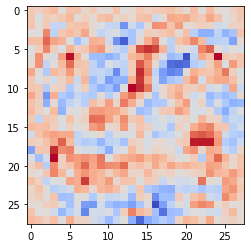

In [21]:
plt.imshow(model['hidden.weight'].numpy()[23].reshape(28,28), cmap = 'coolwarm')

In [22]:
def draw_weights(weights : np.ndarray,
                 reshape_dim : tuple([int, int]) = (28, 28),
                 max_per_row : int = 5,
                 max_rows : int = 5,
                 fig = None,\
                plot = False): 
    """
    Plot the first few weights as matrices. `weights` should be an array of shape (output_dim, input_dim), i.e.
    `weights[i,j]` is the weight connecting the $j$-th neuron of a layer $n$ to the $i$-th neuron of the $n+1$ layer.
    Namely, all the weights connected to the $i$-th output neuron are the ones in the $i$-th row of `weights`.
    These weights are reshaped according to `reshape_dim` to construct a matrix. The weight matrices of the first neurons
    are then plotted in a grid of up to `max_rows` rows and `max_per_row` columns. 
    """
    
    #Shape of weights is (output_dim, input_dim)
    
    if fig is None:
        fig = plt.figure()
    else:
        plt.clf() #Clears the current figure
    
    nc = np.max(np.abs(weights)) #(Absolute) range of weights
    
    n_neurons = weights.shape[0] 
    
    #---Infer number of rows/columns---#
    n_columns = max_per_row
    n_rows = n_neurons // max_per_row
    

    # Code for showing the weights for each neuron one big image containting all the weights
    
    # Limiting the number of rows to the maximum number needed for a decent visualization
    if n_rows > max_rows:
        n_rows = max_rows
    if n_rows == 1:
        n_columns = n_neurons

    # Limiting the number of neurons to be plotted to the maximum number needed for a decent visualization
    if n_neurons > max_rows * max_per_row:
        n_neurons = max_rows * max_per_row


    
    #---Generate grid---#
    whole_image = np.zeros(reshape_dim * np.array([n_rows, n_columns])) #The created array has shape (n_rows * reshape_dim[0], n_columns * reshape_dim[1])
    
    i_row = 0
    i_col = 0
    size_x, size_y = reshape_dim
    
    plt.tight_layout()
    
    # Put each weight matrix in the right place in the grid
    for index_neuron in range(n_neurons):
        img = weights[index_neuron,].reshape(reshape_dim)
        whole_image[i_row * size_x:(i_row+1) * size_x,i_col * size_y:(i_col+1) * size_y] = img
        i_col += 1
        
        if (i_col >= n_columns):
            i_col = 0
            i_row += 1
    
    
    
    img_plotted = plt.imshow(whole_image, cmap='bwr', vmin=-nc, vmax=nc, interpolation=None)
    
    fig.colorbar(img_plotted, orientation = 'vertical', ax = plt.gca(),ticks=[np.amin(whole_image), 0, np.amax(whole_image)])
    #plt.axis('off')
    if plot:
        plt.show()

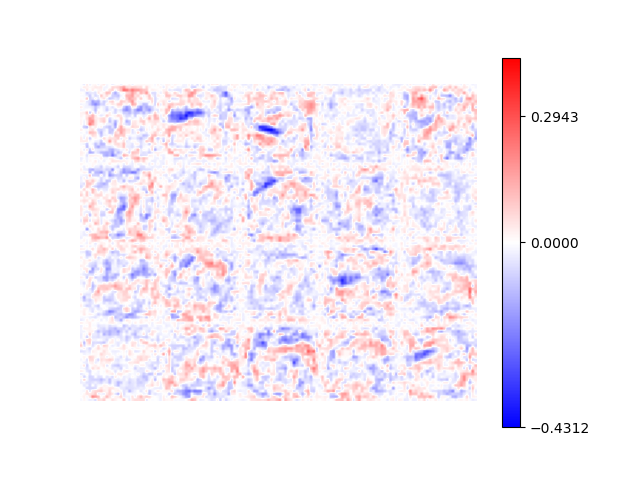

In [25]:
%matplotlib ipympl
np.random.seed(77)#10
idxPlot = np.random.randint(low = 0, high = 1999, size = 20)
weights = model['hidden.weight'].numpy()
weightsPlots = weights[idxPlot]
draw_weights(weightsPlots)
plt.axis('off')
plt.savefig('weightsSupervised.png', transparent=True, bbox_inches='tight')